In [1]:
import numpy as np
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import math, copy, sys, os
from torch.autograd import Variable
import pickle
import csv
import re, random, string, subprocess, time
from model.cnn_rnn_decoder import GRU_Decoder_With_Attention
from model.cnn_rnn_encoder import *
import sacrebleu
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.font_manager as mfm

font_path = "/Users/qintai/Desktop/SimHei.ttf"
prop = mfm.FontProperties(fname=font_path)

# Load model and data(Vi)

In [2]:
TEXT_vi = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = True, tokenize= lambda t:t.split(),
                                        include_lengths=True)
TEXT_en = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = False, tokenize= lambda t:t.split(),
                              lower=True, init_token='<sos>', eos_token='<eos>',include_lengths=True)

train_vi_en = torchtext.data.TabularDataset('../text_data/train_vi_en.csv', format='csv', 
                             fields=[('source',TEXT_vi),('target',TEXT_en)])
validation_vi_en = torchtext.data.TabularDataset('../text_data/dev_vi_en.csv', format='csv', 
                             fields=[('source',TEXT_vi),('target',TEXT_en)])
text_vi_en = torchtext.data.TabularDataset('../text_data/test_vi_en.csv', format='csv', 
                             fields=[('source',TEXT_vi),('target',TEXT_en)])
text_vi_en_heap = torchtext.data.TabularDataset('../text_data/test_vi_en_heap.csv', format='csv', 
                             fields=[('source',TEXT_vi),('target',TEXT_en)])



TEXT_vi.build_vocab(train_vi_en, min_freq=3)
TEXT_en.build_vocab(train_vi_en, min_freq=3)


train_vi_en_iter = torchtext.data.BucketIterator(train_vi_en, batch_size=1, sort_key= lambda e: len(e.source),
                             repeat = False, sort_within_batch=True, shuffle=True, device=torch.device(0))
validation_vi_en_iter = torchtext.data.BucketIterator(validation_vi_en, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))
text_vi_en_iter = torchtext.data.BucketIterator(text_vi_en, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))

text_vi_en_iter_heap = torchtext.data.BucketIterator(text_vi_en_heap, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))


        

In [3]:
encoder_1 = torch.load('../model/rnn_cnn_vi/encoder_1')
decoder_1 = torch.load('../model/rnn_cnn_vi/decoder_1')

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by acc

# Validation bleu score Vi

In [4]:

        
        
class Bean_Search_Status_Record:
    
    def __init__(self, h_t, predict_word_index_list, sum_log_prob):
        self.h_t = h_t
        self.predict_word_index_list = predict_word_index_list
        self.sum_log_prob = sum_log_prob
        self.avg_log_prob = 0
        
    

def test(encoder, decoder, data_iter, path_name_name,k=10):
    encoder.eval()
    decoder.eval()

    path_name = '../eval/'+path_name_name+'/'
    os.mkdir(path_name)

    predict_file_name = path_name + 'predict.txt'
    target_file_name = path_name + 'target_file_name.txt'

    predict_file = open(predict_file_name, 'w')
    target_file = open(target_file_name, 'w')


    for batch in data_iter:
        
        
        
        source, target = batch.source, batch.target
        

        source_data,source_len = source[0], source[1]
        target_data,target_len = target[0], target[1]
        
        all_output = encoder(source_data)
        output = all_output[0,:]
        
        target_word = torch.tensor([TEXT_en.vocab.stoi['<sos>']]).cuda(0)

        h_t = output[0,:]
        h_t = h_t.view([1,1,-1])

        is_init = True


        right_whole_sentence_word_index = target_data[1: target_len[0].item()-1,0]
        right_whole_sentence_word_index = list(right_whole_sentence_word_index.cpu().numpy())
        
        
        sequences = [Bean_Search_Status_Record(h_t, predict_word_index_list = [target_word], 
                                               sum_log_prob = 0.0)]
        
        t = 0
        while (t < 100):
            all_candidates = []
            for i in range(len(sequences)):
                record = sequences[i]
                h_t = record.h_t
                predict_word_index_list = record.predict_word_index_list
                sum_log_prob = record.sum_log_prob
                target_word = predict_word_index_list[-1]
                
                if TEXT_en.vocab.stoi['<eos>'] != target_word:
                
                    prob, h_t = decoder(torch.tensor([target_word]).cuda(0), h_t, output, is_init)

                    k_prob_value_list, k_word_index_list = prob.topk(k,dim=1)
                    k_prob_value_list = k_prob_value_list.cpu().detach().squeeze().numpy()
                    k_word_index_list = k_word_index_list.cpu().squeeze().numpy()
                    
                    
                    for prob_value, word_index in zip(k_prob_value_list, k_word_index_list):
                        prob_value = float(prob_value)
                        word_index = int(word_index)
                        new_record = Bean_Search_Status_Record(h_t, predict_word_index_list+[word_index], sum_log_prob+prob_value)
                        new_record.avg_log_prob = new_record.sum_log_prob/((4+len(new_record.predict_word_index_list))**0.6/(6)**0.6)
                        
                        all_candidates.append(new_record)
                else:
                    all_candidates.append(record)
            is_init = False
                        
            ordered = sorted(all_candidates, key = lambda r: r.avg_log_prob, reverse = True)
            sequences = ordered[:k]
            
            t += 1
        final_record = sequences[0]
        
        predict_whole_sentence_word_index = [TEXT_en.vocab.itos[temp_index] for temp_index in final_record.predict_word_index_list[1:-1]]
        right_whole_sentence_word_index = [TEXT_en.vocab.itos[temp_index] for temp_index in right_whole_sentence_word_index]

        predict_whole_sentence = ' '.join(predict_whole_sentence_word_index)
        right_whole_sentence = ' '.join(right_whole_sentence_word_index)

        predict_file.write(predict_whole_sentence.strip() + '\n')
        target_file.write(right_whole_sentence.strip() + '\n')


    predict_file.close()
    target_file.close()

    result = subprocess.run('cat {} | sacrebleu {}'.format(predict_file_name,target_file_name),shell=True,stdout=subprocess.PIPE)
    result = str(result)
    print(result)
    sys.stdout.flush()
    
    
    return get_blue_score(result)


def get_blue_score(s):
    a = re.search(r'13a\+version\.1\.2\.12 = ([0-9.]+)',s)
    return float(a.group(1))



In [6]:
test(encoder_1, decoder_1, validation_vi_en_iter, path_name_name='beam_search_cnn_rnn_vi_val')

CompletedProcess(args='cat ../eval/beam_search_cnn_rnn_vi_val/predict.txt | sacrebleu ../eval/beam_search_cnn_rnn_vi_val/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 18.3 51.6/24.2/13.3/7.7 (BP = 0.967 ratio = 0.967 hyp_len = 27348 ref_len = 28275)\n')


18.3

# test data blue score Vi

In [7]:
test(encoder_1, decoder_1, text_vi_en_iter, path_name_name='beam_search_cnn_rnn_vi_test')

CompletedProcess(args='cat ../eval/beam_search_cnn_rnn_vi_test/predict.txt | sacrebleu ../eval/beam_search_cnn_rnn_vi_test/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 18.2 51.8/24.0/13.7/8.3 (BP = 0.940 ratio = 0.942 hyp_len = 28265 ref_len = 30012)\n')


18.2

# show heatmap for the attention show heatmap for the attention

modify decoder to return weight vector

In [10]:
from cnn_rnn_decoder_heatmap import GRU_Decoder_With_Attention
decoder_1 = torch.load('../model/rnn_cnn_vi/decoder_1')

In [20]:
def showAttention(input_sentence, output_words, attentions):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)


    ax.set_xticklabels([''] + output_words, rotation=90,fontproperties=prop)
    ax.set_yticklabels([''] + input_sentence,fontproperties=prop)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
class Bean_Search_Status_Record:
    
    def __init__(self, h_t, predict_word_index_list, sum_log_prob, weight_matrix=None):
        self.h_t = h_t
        self.predict_word_index_list = predict_word_index_list
        self.sum_log_prob = sum_log_prob
        self.avg_log_prob = 0
        self.weight_matrix = weight_matrix
        
        
        


        
        
        
        

def draw_attention(encoder, decoder, data_iter, TEXT_en, TEXT_source, k=10):
    encoder.eval()
    decoder.eval()

    path_name = '../eval/'+str(time.time()).replace('.','_')+'/'
    os.mkdir(path_name)
    predict_file_name = path_name + 'predict.txt'
    target_file_name = path_name + 'target_file_name.txt'

    predict_file = open(predict_file_name, 'w')
    target_file = open(target_file_name, 'w')


    for batch in data_iter:
        
        
        
        source, target = batch.source, batch.target
        

        source_data,source_len = source[0], source[1]
        target_data,target_len = target[0], target[1]
        
        all_output = encoder(source_data)
        output = all_output[0,:]
        
        target_word = torch.tensor([TEXT_en.vocab.stoi['<sos>']]).cuda(0)

        h_t = output[0,:]
        h_t = h_t.view([1,1,-1])

        is_init = True

        
        right_whole_sentence_word_index = target_data[1: target_len[0].item()-1,0]
        right_whole_sentence_word_index = list(right_whole_sentence_word_index.cpu().numpy())
        left_whole_sentence_word_index = source_data[0,:source_len.item()]
        left_whole_sentence_word_index = list(left_whole_sentence_word_index.cpu().numpy())
        
        weight_matrix = np.array([]).reshape(output.shape[0],0)
        
        
        
        sequences = [Bean_Search_Status_Record(h_t, predict_word_index_list = [target_word], 
                                               sum_log_prob = 0.0, weight_matrix = weight_matrix)]
        
        t = 0
        while (t < 100):
            all_candidates = []
            for i in range(len(sequences)):
                record = sequences[i]
                h_t = record.h_t
                predict_word_index_list = record.predict_word_index_list
                weight_matrix = record.weight_matrix
                sum_log_prob = record.sum_log_prob
                target_word = predict_word_index_list[-1]
                
                if TEXT_en.vocab.stoi['<eos>'] != target_word:
                
                    prob, h_t, attention = decoder(torch.tensor([target_word]).cuda(0), h_t, output, is_init)
                    attention = attention.cpu().detach().numpy()

                    k_prob_value_list, k_word_index_list = prob.topk(k,dim=1)
                    k_prob_value_list = k_prob_value_list.cpu().detach().squeeze().numpy()
                    k_word_index_list = k_word_index_list.cpu().squeeze().numpy()
                    
                    
                    for prob_value, word_index in zip(k_prob_value_list, k_word_index_list):
                        prob_value = float(prob_value)
                        word_index = int(word_index)
                        new_record = Bean_Search_Status_Record(h_t, predict_word_index_list+[word_index], sum_log_prob+prob_value)
                        new_record.avg_log_prob = new_record.sum_log_prob/((4+len(new_record.predict_word_index_list))**0.6/(6)**0.6)
                        new_record.weight_matrix = np.concatenate([weight_matrix, attention], axis=1)
                        all_candidates.append(new_record)
                else:
                    all_candidates.append(record)
            is_init = False
                        
            ordered = sorted(all_candidates, key = lambda r: r.avg_log_prob, reverse = True)
            sequences = ordered[:k]
            
            t += 1
        final_record = sequences[0]
        
        weight_matrix = final_record.weight_matrix[:,:-1]
        
        predict_whole_sentence_word_index = [TEXT_en.vocab.itos[temp_index] for temp_index in final_record.predict_word_index_list[1:-1]]
        right_whole_sentence_word_index = [TEXT_en.vocab.itos[temp_index] for temp_index in right_whole_sentence_word_index]
        
        left_whole_sentence_word_index = [TEXT_source.vocab.itos[temp_index] for temp_index in left_whole_sentence_word_index]
        
        showAttention(left_whole_sentence_word_index,predict_whole_sentence_word_index,weight_matrix)
        predict_whole_sentence = ' '.join(predict_whole_sentence_word_index)
        right_whole_sentence = ' '.join(right_whole_sentence_word_index)

        predict_file.write(predict_whole_sentence.strip() + '\n')
        target_file.write(right_whole_sentence.strip() + '\n')


    predict_file.close()
    target_file.close()





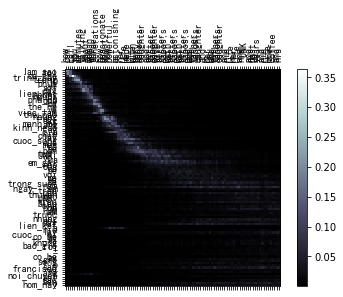

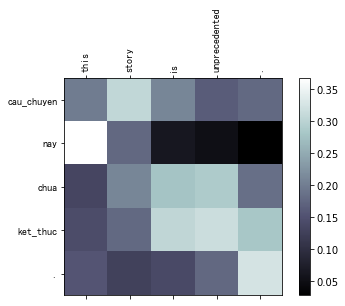

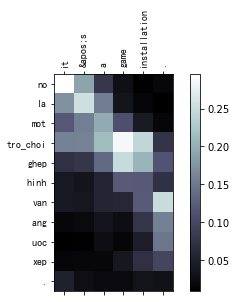

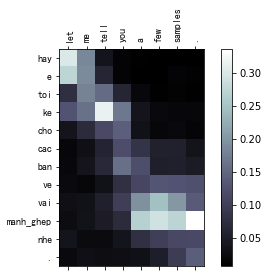

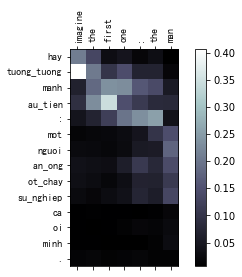

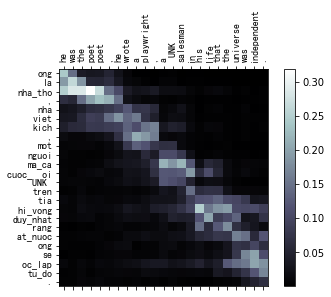

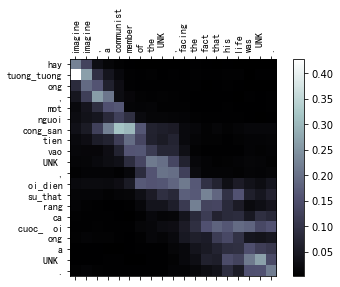

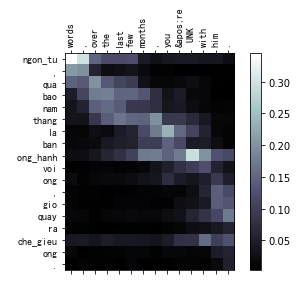

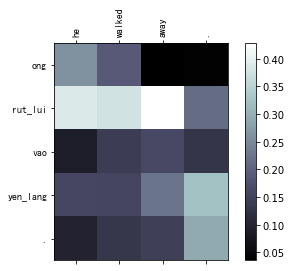

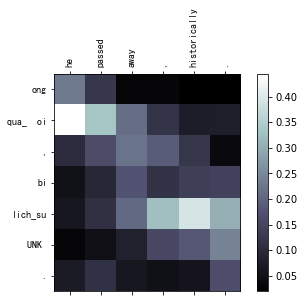

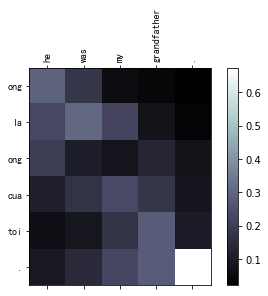

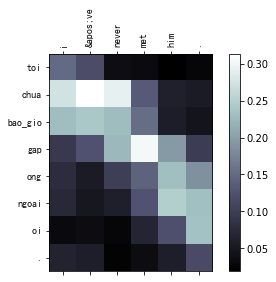

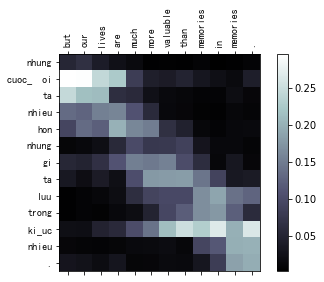

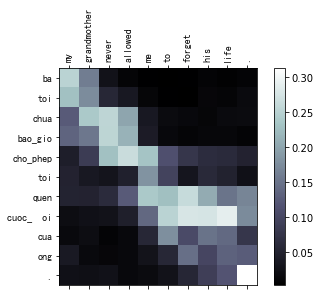

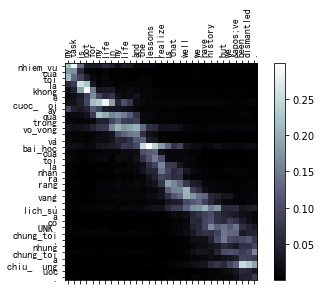

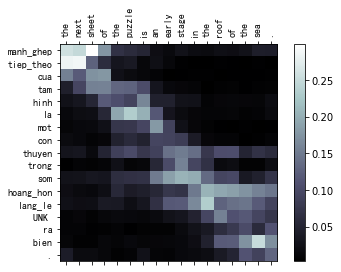

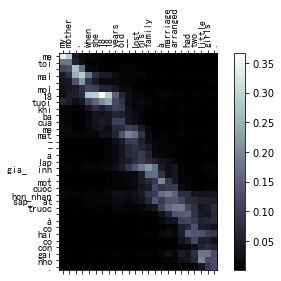

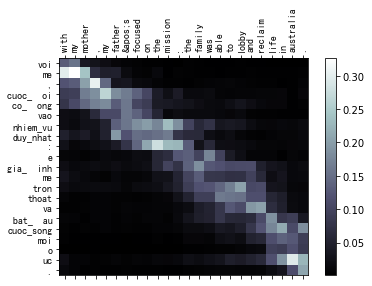

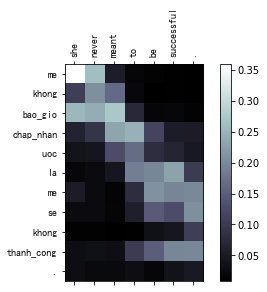

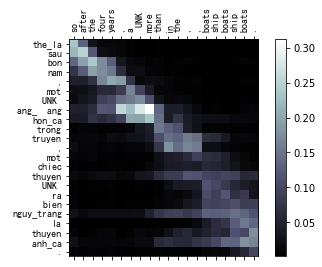

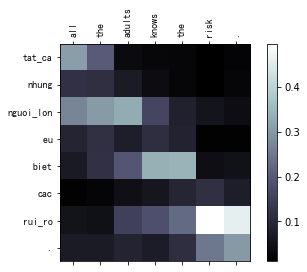

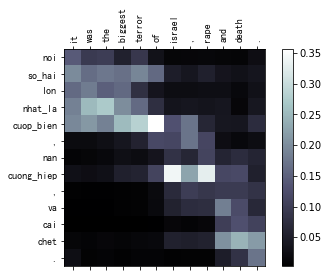

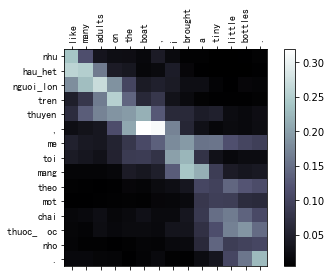

In [24]:
draw_attention(encoder_1, decoder_1, text_vi_en_iter_heap, TEXT_en, TEXT_vi)

# relationship between blue score and sentence length

In [8]:
predict = list(open('../eval/beam_search_cnn_rnn_vi_test/predict.txt'))
target = list(open('../eval/beam_search_cnn_rnn_vi_test/target_file_name.txt'))

def classify_length(predict, target,l1, l2):
    pre1=[]
    tar1=[]
    if l1<50:
        for i in range(len(target)):
            if len(target[i].split())>=l1 and len(target[i].split())<l2:
                pre1.append(predict[i])
                tar1.append(target[i])
        score= sacrebleu.corpus_bleu(pre1,[tar1]).score
        a =str('The bleu score for the text length from {} to {}'.format(l1,l2))                
    else:
        for i in range(len(target)):
            if len(target[i].split())>=l1:
                pre1.append(predict[i])
                tar1.append(target[i])                
        score= sacrebleu.corpus_bleu(pre1,[tar1]).score
        a =str('The bleu score for the text length larger than {}'.format(l1))
    result = (a, score)
    
    return result

result = []
for i in range(12):
    result.append(classify_length(predict,target,i*5,(i+1)*5))
result.append(classify_length(predict,target,60,500))          

result

[('The bleu score for the text length from 0 to 5', 28.8343854228747),
 ('The bleu score for the text length from 5 to 10', 23.20016662348712),
 ('The bleu score for the text length from 10 to 15', 20.039093138240464),
 ('The bleu score for the text length from 15 to 20', 20.42798676727214),
 ('The bleu score for the text length from 20 to 25', 18.34928126342944),
 ('The bleu score for the text length from 25 to 30', 17.04336237022802),
 ('The bleu score for the text length from 30 to 35', 17.167105290885917),
 ('The bleu score for the text length from 35 to 40', 14.278194135661414),
 ('The bleu score for the text length from 40 to 45', 16.542504393451512),
 ('The bleu score for the text length from 45 to 50', 13.055445582064413),
 ('The bleu score for the text length larger than 50', 12.727402594206815),
 ('The bleu score for the text length larger than 55', 10.338387862233798),
 ('The bleu score for the text length larger than 60', 8.195855985067473)]

In [9]:
result = np.array([(int(item[0].split(' ')[-1]),item[1]) for item in result])

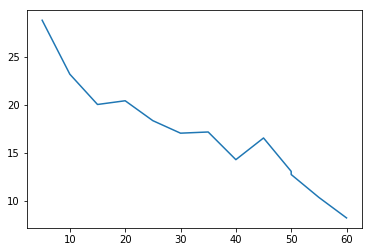

In [10]:
plt.plot(result[:,0],result[:,1])

# Load zh data and three models

In [11]:
TEXT_zh = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = True, tokenize= lambda t:t.split(),
                                        include_lengths=True)
TEXT_en = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = False, tokenize= lambda t:t.split(),
                              lower=True, init_token='<sos>', eos_token='<eos>',include_lengths=True)
train_zh_en = torchtext.data.TabularDataset('../text_data/train_zh_en.csv', format='csv', 
                             fields=[('source',TEXT_zh),('target',TEXT_en)])
validation_zh_en = torchtext.data.TabularDataset('../text_data/dev_zh_en.csv', format='csv', 
                             fields=[('source',TEXT_zh),('target',TEXT_en)])
test_zh_en = torchtext.data.TabularDataset('../text_data/test_zh_en.csv', format='csv', 
                             fields=[('source',TEXT_zh),('target',TEXT_en)])
test_zh_en_heap = torchtext.data.TabularDataset('../text_data/test_zh_en_heap.csv', format='csv', 
                             fields=[('source',TEXT_zh),('target',TEXT_en)])




TEXT_zh.build_vocab(train_zh_en, min_freq=3)
TEXT_en.build_vocab(train_zh_en, min_freq=3)


validation_zh_en_iter = torchtext.data.BucketIterator(validation_zh_en, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))
test_zh_en_iter = torchtext.data.BucketIterator(test_zh_en, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))
test_zh_en_iter_heap = torchtext.data.BucketIterator(test_zh_en_heap, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))


In [18]:
encoder_1 = torch.load('../model/rnn_cnn_zh/encoder_1')
decoder_1 = torch.load('../model/rnn_cnn_zh/decoder_1')

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by acc

# validation bleu score for each model ZH

In [13]:
test(encoder_1, decoder_1, validation_zh_en_iter, path_name_name='beam_search_cnn_rnn_zh_val')

CompletedProcess(args='cat ../eval/beam_search_cnn_rnn_zh_val/predict.txt | sacrebleu ../eval/beam_search_cnn_rnn_zh_val/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 12.6 44.7/17.6/8.5/4.6 (BP = 0.950 ratio = 0.951 hyp_len = 27807 ref_len = 29243)\n')


12.6

# test bleu score for model ZH

In [14]:
test(encoder_1, decoder_1, test_zh_en_iter, path_name_name='beam_search_cnn_rnn_zh_test')

CompletedProcess(args='cat ../eval/beam_search_cnn_rnn_zh_test/predict.txt | sacrebleu ../eval/beam_search_cnn_rnn_zh_test/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 13.4 47.8/19.6/10.2/5.8 (BP = 0.874 ratio = 0.881 hyp_len = 23867 ref_len = 27091)\n')


13.4

# show heatmap for the attention show heatmap for the attention

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'cnn_rnn_decoder_heatmap.GRU_Decoder_With_Attention' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRU' has changed. you can retrieve the original source code b

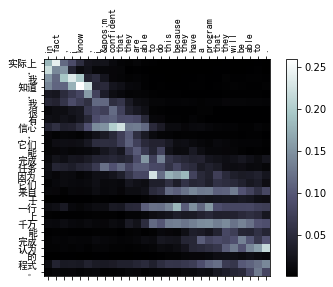

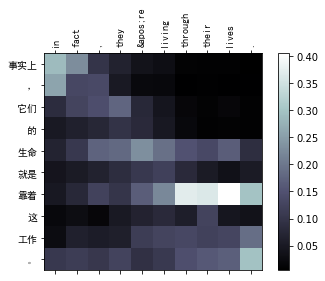

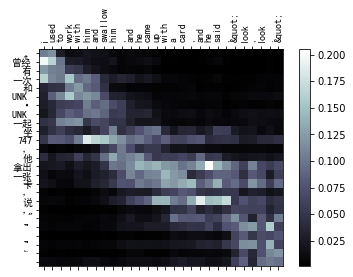

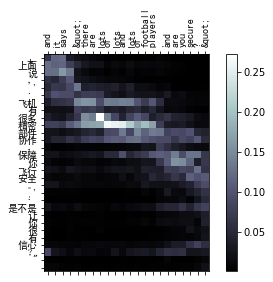

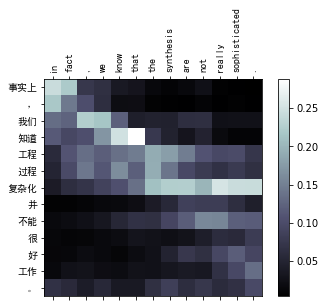

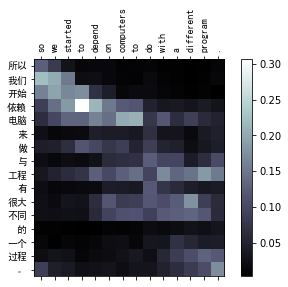

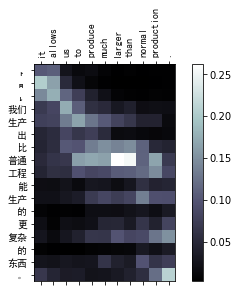

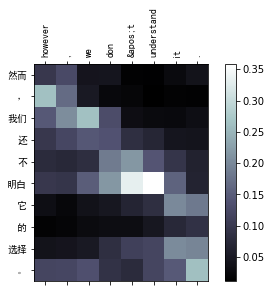

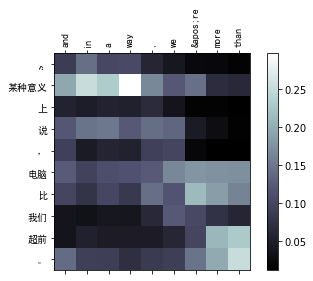

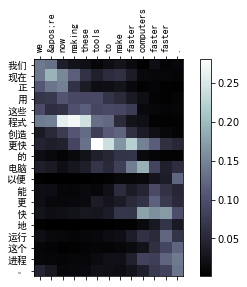

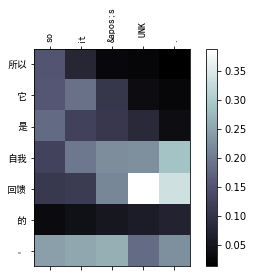

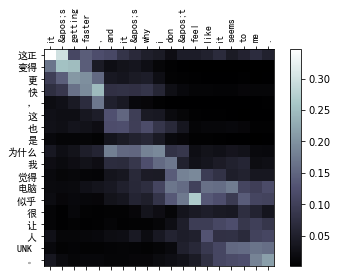

In [21]:
from cnn_rnn_decoder_heatmap import GRU_Decoder_With_Attention
decoder_1 = torch.load('../model/rnn_cnn_zh/decoder_1')

draw_attention(encoder_1, decoder_1, test_zh_en_iter_heap, TEXT_en, TEXT_zh)

# relationship between blue score and sentence length

In [15]:
predict = list(open('../eval/beam_search_cnn_rnn_zh_test/predict.txt'))
target = list(open('../eval/beam_search_cnn_rnn_zh_test/target_file_name.txt'))
result = []
for i in range(12):
    result.append(classify_length(predict,target,i*5,(i+1)*5))
result.append(classify_length(predict,target,60,500))          

result

[('The bleu score for the text length from 0 to 5', 21.87265519763782),
 ('The bleu score for the text length from 5 to 10', 18.48061283587969),
 ('The bleu score for the text length from 10 to 15', 15.64541061892672),
 ('The bleu score for the text length from 15 to 20', 13.439363345496679),
 ('The bleu score for the text length from 20 to 25', 12.573622296685068),
 ('The bleu score for the text length from 25 to 30', 13.959850860271496),
 ('The bleu score for the text length from 30 to 35', 11.994824154231766),
 ('The bleu score for the text length from 35 to 40', 11.183251427130365),
 ('The bleu score for the text length from 40 to 45', 12.525542486032057),
 ('The bleu score for the text length from 45 to 50', 7.898612839834797),
 ('The bleu score for the text length larger than 50', 9.239901572106875),
 ('The bleu score for the text length larger than 55', 8.402903636338086),
 ('The bleu score for the text length larger than 60', 7.867118826513816)]

In [16]:
result = np.array([(int(item[0].split(' ')[-1]),item[1]) for item in result])

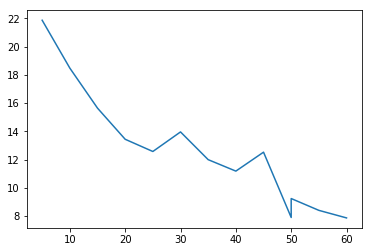

In [17]:
plt.plot(result[:,0],result[:,1])